In [1]:
import networkx as nx
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

def gen_graph(board):
    G = nx.Graph()
    x, y = board.shape
    G.add_nodes_from(list(range(1,(x*y)+1)))
    for i in range(x):
        for j in range(y):
            vertice_id = ((i*y) + j) + 1
            ix = i+1
            jy = j+1
            G.nodes[vertice_id]['ignore'] = False
            G.nodes[vertice_id]['label'] = "{},{}".format(ix,jy)
            G.nodes[vertice_id]['index'] = "{},{}".format(i,j)
            G.nodes[vertice_id]['value'] = board[i,j]
            if i-1 > -1:
                pos_top = (((i-1)*y) + j) + 1
                G.add_edge(vertice_id, pos_top, position='T')
            if i+1 < x:
                pos_bottom = (((i+1)*y) + j) + 1
                G.add_edge(vertice_id, pos_bottom, position='B')
            if j-1 > -1:
                pos_left = ((i*y) + (j-1)) + 1
                G.add_edge(vertice_id, pos_left, position='L')
            if j+1 < y:
                pos_right = ((i*y) + (j+1)) + 1
                G.add_edge(vertice_id, pos_right, position='R')
    return G


def find_distinct_set(list_sets, new_set):
    def happens_intersection(set1, set2):
        for element in set1: 
            if element in set2:
                return True
        return False
    # End of internal function happens_intersection
    
    for elem_set in list_sets:
        if not happens_intersection(elem_set, new_set):
            return elem_set
    return None


def search_snakes(graph, snake_size):
    sums = {}
    
    def dfs_7snakes(graph, new_snake, vertice_id, val_sum, num_snake_piece, max_snake_size):
        found = None
        if num_snake_piece == 1:
            new_snake = set([vertice_id])

        if num_snake_piece == max_snake_size:
            this_snake = set(list(new_snake) + [vertice_id])
            final_sum = val_sum + graph.nodes[vertice_id]['value']
            if final_sum in sums:
                # Checks if exists other snake without overposition
                other_snake = find_distinct_set(sums[final_sum], this_snake)
                if other_snake is not None:
                    return other_snake, this_snake, final_sum
                else:
                    sums[final_sum].append(this_snake)
            else:
                sums[final_sum] = [this_snake]
            return None
        
        # Only no visited nodes to avoid snake loops itself
        neighbors_to_go = set(list(graph.neighbors(vertice_id))) - new_snake
        
        if len(neighbors_to_go) > 0:
            for vertice in neighbors_to_go:
                if not graph.nodes[vertice]['ignore']:
                    found = dfs_7snakes(graph, new_snake | set([vertice_id]), vertice, val_sum + graph.nodes[vertice]['value'], num_snake_piece + 1, max_snake_size)
                    if found is not None:
                        return found
        return found
    # End of internal function dfs_7snakes
    
    for vertice in graph.nodes:
        pair = dfs_7snakes(graph, None, vertice, 0, 1, snake_size)
        if pair:
            return pair
        else:
            graph.nodes[vertice]['ignore'] = True
    return pair


def decode_coord_label(graph, board, pair):
    snake1, snake2, summation = pair
    coord_snake1 = []
    coord_snake2 = []    
    for vertice_id in snake1:
        coord = graph.nodes[vertice_id]['label'].split(",")
        coord_snake1.append((int(coord[0]),int(coord[1])))

    for vertice_id in snake2:
        coord = graph.nodes[vertice_id]['label'].split(",")
        coord_snake2.append((int(coord[0]),int(coord[1])))

    return coord_snake1, coord_snake2, summation


def map_snakes_matrix(graph, board, pair):
    bd = np.zeros(board.shape)
    bd_plot = np.zeros(board.shape)
    snake1, snake2, summ = pair
    for vertice_id in snake1:
        coord = graph.nodes[vertice_id]['index'].split(",")
        bd[int(coord[0]),int(coord[1])] = board[int(coord[0]),int(coord[1])]
        bd_plot[int(coord[0]),int(coord[1])] = 10

    for vertice_id in snake2:
        coord = graph.nodes[vertice_id]['index'].split(",")
        bd[int(coord[0]),int(coord[1])] = board[int(coord[0]),int(coord[1])]
        bd_plot[int(coord[0]),int(coord[1])] = 100

    return bd, bd_plot

def plot_snakes_board(board):
    plt.clf()
    #https://stackoverflow.com/questions/19586828/drawing-grid-pattern-in-matplotlib
    data = np.ones((board.shape)) * np.nan
    x, y = board.shape
    for i in range(x):
        for j in range(y):
            if board[i,j]:
                data[i,j] = board[i,j]
                   
    # make a figure + axes
    fig, ax = plt.subplots(1, 1, tight_layout=True)
    # make color map
    my_cmap = matplotlib.colors.ListedColormap(['r', 'g', 'b'])
    # set the 'bad' values (nan) to be white and transparent
    my_cmap.set_bad(color='w', alpha=0)
    # draw the grid
    for i in range(x + 1):
        ax.axhline(i, lw=2, color='k', zorder=5)
        ax.axvline(i, lw=2, color='k', zorder=5)
    # draw the boxes
    ax.imshow(data, interpolation='none', cmap=my_cmap, extent=[0, x, 0, x], zorder=0)
    # turn off the axis labels
    ax.axis('off')
    plt.show()

In [2]:
board5x5 = np.loadtxt('board5x5_01.csv', delimiter=',', dtype='int')
board10x10 = np.loadtxt('board10x10_01.csv', delimiter=',', dtype='int')
board20x20 = np.loadtxt('board20x20_01.csv', delimiter=',', dtype='int')
board5x5

array([[201, 160,  69, 186,  96],
       [162,   4, 232,  55, 244],
       [241,  64, 196, 244,  35],
       [ 55, 137, 219,  93, 122],
       [212, 168,  86, 200, 101]])

In [3]:
graph_board = gen_graph(board5x5)
graph_board10x10 = gen_graph(board10x10)
graph_board20x20 = gen_graph(board20x20)


In [4]:
graph_board.nodes[21]

{'ignore': False, 'index': '4,0', 'label': '5,1', 'value': 212}

In [5]:
print(graph_board.nodes[13])
for nid in list(nx.all_neighbors(graph_board, 13)):
    print(graph_board.nodes[nid])

{'ignore': False, 'label': '3,3', 'index': '2,2', 'value': 196}
{'ignore': False, 'label': '2,3', 'index': '1,2', 'value': 232}
{'ignore': False, 'label': '3,2', 'index': '2,1', 'value': 64}
{'ignore': False, 'label': '4,3', 'index': '3,2', 'value': 219}
{'ignore': False, 'label': '3,4', 'index': '2,3', 'value': 244}


In [6]:
print(find_distinct_set([set([1,2]), set([3,4])], set([3,5])))
print(find_distinct_set([set([1,2]), set([3,4])], set([5,6])))

{1, 2}
{1, 2}


In [7]:
pair = search_snakes(graph_board, 7)
pair10x10 = search_snakes(graph_board10x10, 7)
pair20x20 = search_snakes(graph_board20x20, 7)
coords5x5 = decode_coord_label(graph_board, board5x5, pair)
print("5x5: {}".format(coords5x5)) # As the coordinates are given as sets, they are sorted
coords10x10 = decode_coord_label(graph_board10x10, board10x10, pair10x10)
print("10x10: {}".format(coords10x10)) 
coords20x20 = decode_coord_label(graph_board20x20, board20x20, pair20x20)
print("20x20: {}".format(coords20x20)) 

5x5: ([(1, 1), (2, 1), (3, 1), (3, 2), (3, 3), (4, 3), (4, 4)], [(1, 2), (1, 3), (1, 4), (1, 5), (2, 3), (2, 4), (2, 5)], 1068)
10x10: ([(1, 1), (5, 1), (2, 1), (6, 1), (3, 1), (7, 1), (4, 1)], [(1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (2, 6), (3, 6)], 1049)
20x20: ([(1, 1), (3, 1), (3, 2), (3, 3), (2, 1), (2, 2), (2, 3)], [(1, 2), (1, 3), (1, 4), (3, 4), (3, 5), (2, 4), (2, 5)], 1051)


In [8]:
pair10x10 = search_snakes(graph_board10x10, 7)

In [9]:
bd, bd_plot = map_snakes_matrix(graph_board, board5x5, pair)
bd_plot

array([[  10.,  100.,  100.,  100.,  100.],
       [  10.,    0.,  100.,  100.,  100.],
       [  10.,   10.,   10.,    0.,    0.],
       [   0.,    0.,   10.,   10.,    0.],
       [   0.,    0.,    0.,    0.,    0.]])

/opt/intel/intelpython3/lib/python3.6/site-packages/matplotlib/figure.py:1743: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


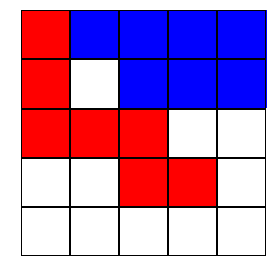

In [10]:
plot_snakes_board(bd_plot)

In [11]:
print(graph_board10x10.nodes[1])
for nid in list(graph_board10x10.neighbors(1)):
    print(nid)
    print(graph_board10x10.nodes[nid])

print(">")
for nid in list(graph_board10x10.edges(1)):
    print(graph_board10x10.nodes[nid[1]])

#pos = nx.spring_layout(graph_board10x10)
#nx.draw(graph_board10x10, with_labels=True)
#plt.show()

{'ignore': True, 'label': '1,1', 'index': '0,0', 'value': 252}
11
{'ignore': False, 'label': '2,1', 'index': '1,0', 'value': 122}
2
{'ignore': False, 'label': '1,2', 'index': '0,1', 'value': 103}
>
{'ignore': False, 'label': '2,1', 'index': '1,0', 'value': 122}
{'ignore': False, 'label': '1,2', 'index': '0,1', 'value': 103}


[[  10.  100.  100.  100.  100.  100.    0.    0.    0.    0.]
 [  10.    0.    0.    0.    0.  100.    0.    0.    0.    0.]
 [  10.    0.    0.    0.    0.  100.    0.    0.    0.    0.]
 [  10.    0.    0.    0.    0.    0.    0.    0.    0.    0.]
 [  10.    0.    0.    0.    0.    0.    0.    0.    0.    0.]
 [  10.    0.    0.    0.    0.    0.    0.    0.    0.    0.]
 [  10.    0.    0.    0.    0.    0.    0.    0.    0.    0.]
 [   0.    0.    0.    0.    0.    0.    0.    0.    0.    0.]
 [   0.    0.    0.    0.    0.    0.    0.    0.    0.    0.]
 [   0.    0.    0.    0.    0.    0.    0.    0.    0.    0.]]
({1, 41, 11, 51, 21, 61, 31}, {2, 3, 4, 5, 6, 16, 26}, 1049)
([(1, 1), (5, 1), (2, 1), (6, 1), (3, 1), (7, 1), (4, 1)], [(1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (2, 6), (3, 6)], 1049)


/opt/intel/intelpython3/lib/python3.6/site-packages/matplotlib/figure.py:1743: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


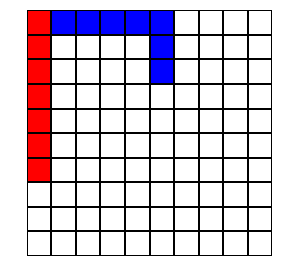

In [12]:
bd, bd_plot10 = map_snakes_matrix(graph_board10x10, board10x10, pair10x10)
print(bd_plot10)
print(pair10x10)
print(coords10x10)
plot_snakes_board(bd_plot10)

/opt/intel/intelpython3/lib/python3.6/site-packages/matplotlib/figure.py:1743: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


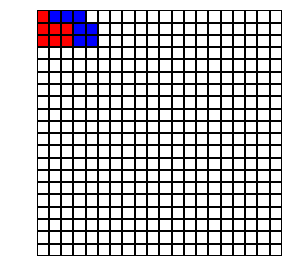

In [13]:
bd, bd_plot20 = map_snakes_matrix(graph_board20x20, board20x20, pair20x20)
plot_snakes_board(bd_plot20)

In [14]:
np.savetxt('snakes_board5x5_01.csv', X=bd, delimiter=',', fmt='%d')
np.savetxt('snakes_board10x10_01.csv', X=bd, delimiter=',', fmt='%d')
np.savetxt('snakes_board20x20_01.csv', X=bd, delimiter=',', fmt='%d')